## p52_polynomial_basis_choice

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display
import pandas as pd
from matplotlib import cm
from numpy.polynomial import Legendre
import scipy.special

def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

def fit_vandermonde_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit polynomial using Vandermonde basis and pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    
    # Create Vandermonde matrix: [1, x, x^2, ..., x^degree]
    X_train_poly = np.vander(x_scaled, N=degree + 1, increasing=True)
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_vandermonde_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate polynomial with given coefficients in Vandermonde basis"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    
    # Create Vandermonde matrix: [1, x, x^2, ..., x^degree]
    X_poly = np.vander(x_scaled, N=degree + 1, increasing=True)
    return X_poly @ beta

In [9]:
random_seed=428
n_points=10
noise_level=0.2

In [10]:
def f(x): return 0.5*(x**2)
# def f(x): return 0.5*(x**4-3*x**2) #This this for a minute. 
# def f(x): return np.add(2.0 * x, np.cos(x * 25)) #[:, 0]

def get_noisy_data(n_points=10, noise_level=0.2, random_seed=428):
    np.random.seed(random_seed) 
    x=np.random.uniform(-2, 2, n_points)
    y=f(x)+noise_level*np.random.randn(n_points)
    return x,y

all_x = np.linspace(-2, 2, 128)
all_y = f(all_x)

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points
x,y=get_noisy_data(n_points, noise_level, random_seed)
                   
x_train=x[:n_train_points]
y_train=y[:n_train_points]
x_test=x[n_train_points:]
y_test=y[n_train_points:]

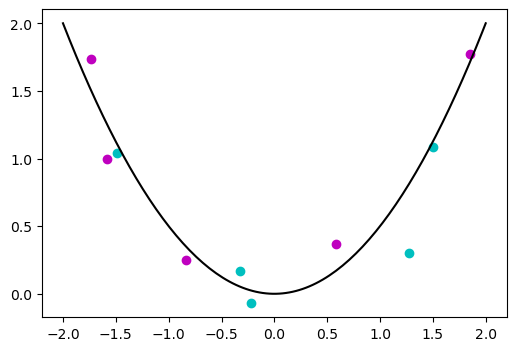

In [11]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')
# plt.ylim([-0.5, 2])

In [16]:
CHILL_BROWN='#948979'
YELLOW='#ffd35a'
YELLOW_FADE='#7f6a2d'
BLUE='#65c8d0'
GREEN='#00a14b' #6e9671' 
CHILL_GREEN='#6c946f'
CHILL_BLUE='#3d5c6f'
FRESH_TAN='#dfd0b9'
CYAN='#00FFFF'
TEST_BLUE='#008080' 

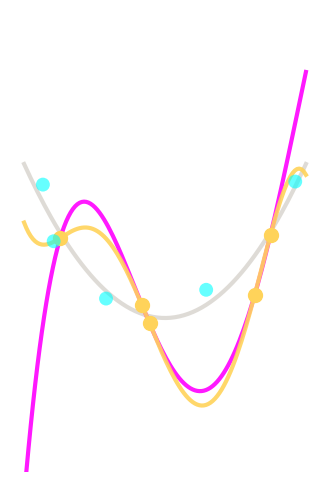

In [35]:
degrees = [1, 2, 3, 4, 5] # 6, 7, 8, 9, 10] #6, 7, 8, 10, 20, 30, 50, 100]
train_errors = []
test_errors = []

# Get colormap
# colors = [GREEN, YELLOW, BLUE, '#EC92AB', 'FF00FF]

# Create figure with two subplots
fig = plt.figure(0, (4,6))
ax1=fig.add_subplot(111)

# Left subplot: fits
ax1.scatter(x_train, y_train, c=YELLOW, s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c=CYAN, s=100, alpha=0.6, label='Test', zorder=10, edgecolor='none')
ax1.plot(all_x, all_y, CHILL_BROWN, alpha=0.3, label='True function', linewidth=3)

for i, degree in enumerate(degrees):
    # Fit polynomial
    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    # all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    
    y_train_pred = eval_legendre_poly(beta_hat, x_train, degree)
    y_test_pred = eval_legendre_poly(beta_hat, x_test, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)

    # Plot fit
    if degree == 4: ax1.plot(all_x, all_y_fit, color='#FF00FF', label=f'Degree {degree}', alpha=0.9, linewidth=3)
    if degree == 5: ax1.plot(all_x, all_y_fit, color=YELLOW, label=f'Degree {degree}', alpha=0.9, linewidth=3)
    
    # Calculate errors
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)
    train_errors.append(train_error)
    test_errors.append(test_error)

ax1.set_ylim([-2, 4])
plt.axis('off')
plt.savefig('/Users/stephen/Stephencwelch Dropbox/welch_labs/double_descent/graphics/p52_1.svg')

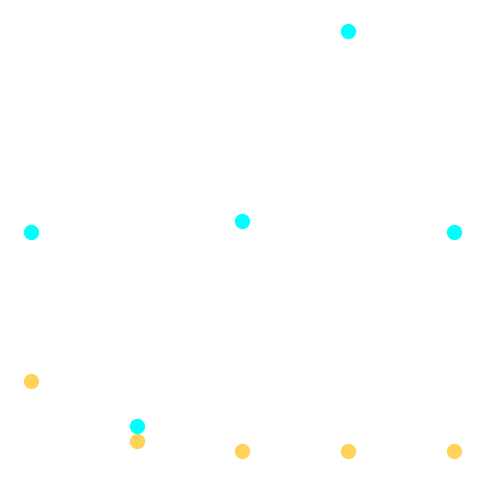

In [41]:
fig = plt.figure(0, (6,6))
ax=fig.add_subplot(111)
ax.scatter(degrees, test_errors, c=CYAN, s=100)
ax.scatter(degrees, train_errors, c=YELLOW, s=100)
plt.axis('off')
plt.savefig('/Users/stephen/Stephencwelch Dropbox/welch_labs/double_descent/graphics/p52_2.svg')

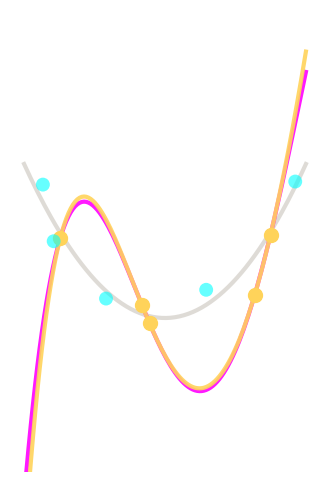

In [42]:
degrees = [1, 2, 3, 4, 5] # 6, 7, 8, 9, 10] #6, 7, 8, 10, 20, 30, 50, 100]
train_errors = []
test_errors = []

# Get colormap
# colors = [GREEN, YELLOW, BLUE, '#EC92AB', 'FF00FF]

# Create figure with two subplots
fig = plt.figure(0, (4,6))
ax1=fig.add_subplot(111)

# Left subplot: fits
ax1.scatter(x_train, y_train, c=YELLOW, s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c=CYAN, s=100, alpha=0.6, label='Test', zorder=10, edgecolor='none')
ax1.plot(all_x, all_y, CHILL_BROWN, alpha=0.3, label='True function', linewidth=3)

for i, degree in enumerate(degrees):
    # Fit polynomial
    beta_hat = fit_vandermonde_pinv(x_train, y_train, degree)
    # all_y_fit = eval_vandermonde_poly(beta_hat, all_x, degree)
    
    y_train_pred = eval_vandermonde_poly(beta_hat, x_train, degree)
    y_test_pred = eval_vandermonde_poly(beta_hat, x_test, degree)
    all_y_fit = eval_vandermonde_poly(beta_hat, all_x, degree)


    # Plot fit
    if degree == 4: ax1.plot(all_x, all_y_fit, color='#FF00FF', label=f'Degree {degree}', alpha=0.9, linewidth=3)
    if degree == 5: ax1.plot(all_x, all_y_fit, color=YELLOW, label=f'Degree {degree}', alpha=0.9, linewidth=3)
    
    # Calculate errors
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)
    train_errors.append(train_error)
    test_errors.append(test_error)

ax1.set_ylim([-2, 4])
plt.axis('off')
plt.savefig('/Users/stephen/Stephencwelch Dropbox/welch_labs/double_descent/graphics/p52_3.svg')

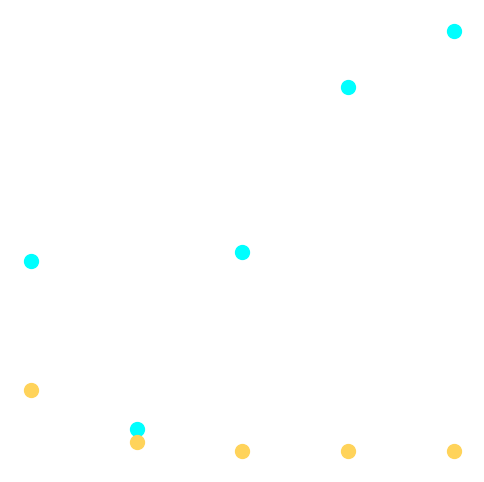

In [43]:
fig = plt.figure(0, (6,6))
ax=fig.add_subplot(111)
ax.scatter(degrees, test_errors, c=CYAN, s=100)
ax.scatter(degrees, train_errors, c=YELLOW, s=100)
plt.axis('off')
plt.savefig('/Users/stephen/Stephencwelch Dropbox/welch_labs/double_descent/graphics/p52_4.svg')